<a href="https://colab.research.google.com/github/dbckz/.vim/blob/master/notebooks/processing_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm
from google.colab import drive
import plotly.graph_objects as go

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set up paths
root_path = "/content/drive/MyDrive/University/Dissertation/data"
day_path = "/FINAL"
directory = root_path + day_path
graph_path = directory + "/graphs"

In [ ]:
# Create directory to store visualisations
try:
    os.mkdir(graph_path)
except OSError as error:
    print(error)

[Errno 17] File exists: '/content/drive/MyDrive/University/Dissertation/data/FINAL/graphs'


In [ ]:
# Load data
tweets_csv = directory + "/tweets.csv"
matched_terms_csv = directory + "/hatebase_processed_tweets_four_letter.csv"
emojis_csv = directory + "/emoji.csv"

print("Loading tweets CSV...")
in_tweets = pd.read_csv(tweets_csv)

print("Loading hatebase CSV...")
hb_guard = pd.read_csv(matched_terms_csv)

print("Loading emojis CSV...")
emojis = pd.read_csv(emojis_csv)

Loading tweets CSV...


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loading hatebase CSV...
Loading emojis CSV...


In [ ]:
# Up the pandas display limits so printed dataframes aren't so truncated
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Data manipulation

In [ ]:
# Join tables
joined_df = pd.merge(in_tweets, emojis, how='outer', on='tweet_id')
joined_df = pd.merge(joined_df, hb_guard, how='outer', on='tweet_id')

In [143]:
# Create a column indicating whether tweet contains slurs (hacky > 2 as empty list is stored as string "[]")
joined_df['contains_slurs'] = joined_df['matching_hatebase_terms_over_70_four_letter'].str.len() > 2
joined_df['contains_ethnicity_slurs'] = joined_df['matching_hatebase_terms_ethnicity_four_letter_over_70'].str.len() > 2
joined_df['contains_nationality_slurs'] = joined_df['matching_hatebase_terms_nationality_four_letter_over_70'].str.len() > 2
joined_df['contains_gender_slurs'] = joined_df['matching_hatebase_terms_gender_four_letter_over_70'].str.len() > 2
joined_df['contains_sexual_orientation_slurs'] = joined_df['matching_hatebase_terms_sexual_orientation_four_letter_over_70'].str.len() > 2
joined_df['contains_class_slurs'] = joined_df['matching_hatebase_terms_class_four_letter_over_70'].str.len() > 2
joined_df['contains_religion_slurs'] = joined_df['matching_hatebase_terms_religion_four_letter_over_70'].str.len() > 2
joined_df['contains_disability_slurs'] = joined_df['matching_hatebase_terms_disability_four_letter_over_70'].str.len() > 2


In [ ]:
emoji_tweet_file = directory + "/emoji_tweets.csv"

banana_tweet_count = emojis['banana_count'][emojis['banana_count'] != 0].count()
monkey_tweet_count = emojis['monkey_count'][emojis['banana_count'] != 0].count()
monkey_face_tweet_count = emojis['monkey_face_count'][emojis['monkey_face_count'] != 0].count()
speak_no_evil_monkey_tweet_count = emojis['speak_no_evil_monkey_count'][emojis['speak_no_evil_monkey_count'] != 0].count()
hear_no_evil_monkey_tweet_count = emojis['hear_no_evil_monkey_count'][emojis['hear_no_evil_monkey_count'] != 0].count()
see_no_evil_monkey_tweet_count = emojis['see_no_evil_monkey_count'][emojis['see_no_evil_monkey_count'] != 0].count()
gorilla_tweet_count = emojis['gorilla_count'][emojis['gorilla_count'] != 0].count()
watermelon_tweet_count = emojis['watermelon_count'][emojis['watermelon_count'] != 0].count()

banana_total = emojis['banana_count'][emojis['banana_count'] != 0].sum()
monkey_total = emojis['monkey_count'][emojis['monkey_count'] != 0].sum()
monkey_face_total = emojis['monkey_face_count'][emojis['monkey_face_count'] != 0].sum()
speak_no_evil_monkey_total = emojis['speak_no_evil_monkey_count'][emojis['speak_no_evil_monkey_count'] != 0].sum()
hear_no_evil_monkey_total = emojis['hear_no_evil_monkey_count'][emojis['hear_no_evil_monkey_count'] != 0].sum()
see_no_evil_monkey_total = emojis['see_no_evil_monkey_count'][emojis['see_no_evil_monkey_count'] != 0].sum()
gorilla_total = emojis['gorilla_count'][emojis['gorilla_count'] != 0].sum()
watermelon_total = emojis['watermelon_count'][emojis['watermelon_count'] != 0].sum()

total_emoji_tweets = emojis.query('banana_count != 0 or monkey_count != 0 or monkey_face_count != 0 or speak_no_evil_monkey_count != 0 or hear_no_evil_monkey_count != 0 or see_no_evil_monkey_count != 0 or gorilla_count != 0 or watermelon_count != 0')['tweet_id'].count()
total_emoji_count = emojis['total_emoji_count'][emojis['total_emoji_count'] != 0].sum()

joined_df[['tweet_id', 'tweet_text']][joined_df['total_emoji_count'] > 0].to_csv(emoji_tweet_file, index=False)

In [ ]:
# NOTE: at this point you need to manually review the emoji tweets in emojit_tweets.csv, and put them into a emoji_tweets_reviewed.csv

reviewed_emojis = pd.read_csv(directory + '/emoji_tweets_reviewed.csv')
reviewed_emojis['manually_reviewed_emoji_is_offensive'] = True
reviewed_emojis.drop('tweet_text', axis=1, inplace=True)
joined_df = pd.merge(joined_df, reviewed_emojis, how='outer', on='tweet_id')
joined_df['manually_reviewed_emoji_is_offensive'] = joined_df['manually_reviewed_emoji_is_offensive'].fillna(False)

In [144]:
# Extract England players
list_of_players = ["JPickford1", "kylewalker2", "LukeShaw23", "_DeclanRice", "HarryMaguire93", "JackGrealish",
                    "JHenderson", "HKane", "sterling7", "MarcusRashford", "trippier2", "deanhenderson",
                    "Kalvinphillips", "OfficialTM_3", "Sanchooo10", "CalvertLewin14", "masonmount_10", "PhilFoden",
                    "BenChilwell", "ben6white", "samjohnstone50", "reecejames_24", "BukayoSaka87", "BellinghamJude"]

for player in list_of_players:
    print(f"Extracting {player}...")
    joined_df[player] = joined_df['accounts_mentioned'].str.contains(f"'username': '{player}'")

player_tweet_map = pd.DataFrame(columns=["username", "tweets_received"])

i = 0
for player in list_of_players:
    tweets = joined_df[player].sum()
    player_tweet_map.loc[i] = player, tweets
    i += 1

player_tweet_map.sort_values('tweets_received', axis=0, ascending=False, inplace=True)

# Sort by ascending date
joined_df.sort_values('created_at', axis=0, inplace=True)
joined_df['created_at'] = pd.to_datetime(joined_df['created_at'])

joined_df['contains_slurs_or_offensive_emoji'] = joined_df['contains_slurs'] | joined_df['manually_reviewed_emoji_is_offensive']
joined_df['contains_ethnicity_slurs'] = joined_df['contains_ethnicity_slurs'] | joined_df['manually_reviewed_emoji_is_offensive'] # assuming all emoji ones are racist

players_only_df = joined_df[
    (joined_df["JPickford1"]) |
    (joined_df["kylewalker2"]) |
    (joined_df["LukeShaw23"]) |
    (joined_df["kylewalker2"]) |
    (joined_df["_DeclanRice"]) |
    (joined_df["HarryMaguire93"]) |
    (joined_df["JackGrealish"]) |
    (joined_df["JHenderson"]) |
    (joined_df["HKane"]) |
    (joined_df["sterling7"]) |
    (joined_df["MarcusRashford"]) |
    (joined_df["trippier2"]) |
    (joined_df["deanhenderson"]) |
    (joined_df["Kalvinphillips"]) |
    (joined_df["OfficialTM_3"]) |
    (joined_df["Sanchooo10"]) |
    (joined_df["CalvertLewin14"]) |
    (joined_df["masonmount_10"]) |
    (joined_df["PhilFoden"]) |
    (joined_df["BenChilwell"]) |
    (joined_df["ben6white"]) |
    (joined_df["samjohnstone50"]) |
    (joined_df["reecejames_24"]) |
    (joined_df["BukayoSaka87"]) |
    (joined_df["BellinghamJude"])
    ]

for player in list_of_players:
    players_only_df[f'{player}_offensive'] = players_only_df['contains_slurs_or_offensive_emoji'] & players_only_df[player]
    players_only_df[f'{player}_ethnicity'] = players_only_df['contains_ethnicity_slurs'] & players_only_df[player]
    players_only_df[f'{player}_nationality'] = players_only_df['contains_nationality_slurs'] & players_only_df[player]
    players_only_df[f'{player}_gender'] = players_only_df['contains_gender_slurs'] & players_only_df[player]
    players_only_df[f'{player}_sexual_orientation'] = players_only_df['contains_sexual_orientation_slurs'] & players_only_df[player]
    players_only_df[f'{player}_class'] = players_only_df['contains_class_slurs'] & players_only_df[player]
    players_only_df[f'{player}_religion'] = players_only_df['contains_religion_slurs'] & players_only_df[player]
    players_only_df[f'{player}_disability'] = players_only_df['contains_disability_slurs'] & players_only_df[player]

Extracting JPickford1...
Extracting kylewalker2...
Extracting LukeShaw23...
Extracting _DeclanRice...
Extracting HarryMaguire93...
Extracting JackGrealish...
Extracting JHenderson...
Extracting HKane...
Extracting sterling7...
Extracting MarcusRashford...
Extracting trippier2...
Extracting deanhenderson...
Extracting Kalvinphillips...
Extracting OfficialTM_3...
Extracting Sanchooo10...
Extracting CalvertLewin14...
Extracting masonmount_10...
Extracting PhilFoden...
Extracting BenChilwell...
Extracting ben6white...
Extracting samjohnstone50...
Extracting reecejames_24...
Extracting BukayoSaka87...
Extracting BellinghamJude...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [146]:
player_offensive_tweet_map = pd.DataFrame(columns=["username",
                                                   "tweets_received",
                                                   "offensive_tweets_received", 
                                                   "ethnicity_tweets_received",
                                                   "nationality_tweets_received",
                                                   "gender_tweets_received",
                                                   "sexual_orientation_tweets_received",
                                                   "class_tweets_received",
                                                   "religion_tweets_received",
                                                   "disability_tweets_received",
                                                   "percentage_offensive"])

i = 0
for player in list_of_players:
    off_tweets = players_only_df[player + '_offensive'].sum()
    ethnicity_tweets = players_only_df[player + '_ethnicity'].sum()
    nationality_tweets = players_only_df[player + '_ethnicity'].sum()
    gender_tweets = players_only_df[player + '_ethnicity'].sum()
    sexual_orientation_tweets = players_only_df[player + '_ethnicity'].sum()
    class_tweets = players_only_df[player + '_ethnicity'].sum()
    religion_tweets = players_only_df[player + '_ethnicity'].sum()
    disability_tweets = players_only_df[player + '_ethnicity'].sum()
    tweets = players_only_df[player].sum()
    percentage = 100 * (off_tweets / tweets)
    player_offensive_tweet_map.loc[i] = player, tweets, off_tweets, ethnicity_tweets, nationality_tweets, gender_tweets, sexual_orientation_tweets, class_tweets, religion_tweets, disability_tweets, percentage
    i += 1

In [161]:
# Create dataframe for analysing abuse by type
slurs_by_type = pd.DataFrame(columns=["type", "total"])
slurs_by_type.loc[0] = "ethnicity", players_only_df['contains_ethnicity_slurs'].sum()
slurs_by_type.loc[1] = "nationality", players_only_df['contains_nationality_slurs'].sum()
slurs_by_type.loc[2] = "gender", players_only_df['contains_gender_slurs'].sum()
slurs_by_type.loc[3] = "sexual_orientation", players_only_df['contains_sexual_orientation_slurs'].sum()
slurs_by_type.loc[4] = "class", players_only_df['contains_class_slurs'].sum()
slurs_by_type.loc[5] = "religion", players_only_df['contains_religion_slurs'].sum()
slurs_by_type.loc[6] = "disability", players_only_df['contains_disability_slurs'].sum()

# Analysis

In [ ]:
# Print some headline figures
print(f"Earliest tweet: {joined_df['created_at'].min()}")
print(f"Latest tweet: {joined_df['created_at'].max()}")

print(f"Number of tweets (including @England, #TakeTheKnee, #BooTheKnee): {len(joined_df)}")
print(f"Number of player-only tweets: {len(players_only_df)}")

Earliest tweet: 2021-07-11 08:56:09+00:00
Latest tweet: 2021-07-16 10:56:39+00:00
Number of tweets (including @England, #TakeTheKnee, #BooTheKnee): 518603
Number of player-only tweets: 423518


In [ ]:
print(player_tweet_map.head(30))

          username tweets_received
9   MarcusRashford          181500
22    BukayoSaka87          121350
14      Sanchooo10           57638
13    OfficialTM_3           37648
5     JackGrealish           35027
7            HKane           22895
4   HarryMaguire93           19069
8        sterling7           14093
2       LukeShaw23           12313
12  Kalvinphillips            8229
0       JPickford1            6820
3      _DeclanRice            6671
6       JHenderson            4938
16   masonmount_10            4114
1      kylewalker2            3224
21   reecejames_24            2996
17       PhilFoden            2553
23  BellinghamJude            2170
10       trippier2            1657
18     BenChilwell            1088
15  CalvertLewin14             579
11   deanhenderson             478
19       ben6white             393
20  samjohnstone50              96


In [ ]:
# Print emoji stats
print(f"{banana_tweet_count} tweets containing banana emoji. {banana_total} banana emojis used in total")
print(f"{monkey_tweet_count} tweets containing monkey emoji. {monkey_total} monkey emojis used in total")
print(f"{monkey_face_tweet_count} tweets containing monkey face emoji. {monkey_face_total} monkey face emojis used in total")
print(f"{speak_no_evil_monkey_tweet_count} tweets containing speak-no-evil monkey emoji. {speak_no_evil_monkey_total} speak-no-evil monkey emojis used in total")
print(f"{hear_no_evil_monkey_tweet_count} tweets containing hear-no-evil monkey emoji. {hear_no_evil_monkey_total} hear-no-evil monkey emojis used in total")
print(f"{see_no_evil_monkey_tweet_count} tweets containing see-no-evil monkey emoji. {see_no_evil_monkey_total} see-no-evil monkey emojis used in total")
print(f"{gorilla_tweet_count} tweets containing gorilla emoji. {gorilla_total} gorilla emojis used in total")
print(f"{watermelon_tweet_count} tweets containing watermelon emoji. {watermelon_total} watermelon emojis used in total")
print(f"{total_emoji_tweets} tweets containing potentially racist emojis. {total_emoji_count} potentially racist emojis used in total")

13 tweets containing banana emoji. 68 banana emojis used in total
13 tweets containing monkey emoji. 298 monkey emojis used in total
11 tweets containing monkey face emoji. 23 monkey face emojis used in total
27 tweets containing speak-no-evil monkey emoji. 44 speak-no-evil monkey emojis used in total
16 tweets containing hear-no-evil monkey emoji. 29 hear-no-evil monkey emojis used in total
216 tweets containing see-no-evil monkey emoji. 276 see-no-evil monkey emojis used in total
12 tweets containing gorilla emoji. 39 gorilla emojis used in total
3 tweets containing watermelon emoji. 7 watermelon emojis used in total
319 tweets containing potentially racist emojis. 784 potentially racist emojis used in total


In [ ]:
print('Five-minute intervals with most offensive tweets:')
print(players_only_df.resample(pd.offsets.Minute(5), on='created_at')['contains_slurs_or_offensive_emoji'].sum().sort_values(ascending=False).head(5))
print('\n')
print('1 hour intervals with most offensive tweets:')
print(players_only_df.resample(pd.offsets.Hour(1), on='created_at')['contains_slurs_or_offensive_emoji'].sum().sort_values(ascending=False).head(5))
print('\n')
print('24 hour intervals with most offensive tweets:')
print(players_only_df.resample(pd.offsets.Day(1), on='created_at')['contains_slurs_or_offensive_emoji'].sum().sort_values(ascending=False).head(5))
print('\n')

tweets_containing_slurs = players_only_df['contains_slurs'].sum()
print(f"{tweets_containing_slurs} tweets containing slurs, {100 * (tweets_containing_slurs / len(players_only_df))}% of all tweets aimed at players")

Five-minute intervals with most offensive tweets:
created_at
2021-07-11 22:50:00+00:00    108
2021-07-11 22:55:00+00:00    101
2021-07-11 22:45:00+00:00     98
2021-07-11 23:00:00+00:00     90
2021-07-11 22:05:00+00:00     86
Name: contains_slurs_or_offensive_emoji, dtype: int64


1 hour intervals with most offensive tweets:
created_at
2021-07-11 22:00:00+00:00    953
2021-07-11 23:00:00+00:00    623
2021-07-12 20:00:00+00:00    215
2021-07-12 21:00:00+00:00    170
2021-07-12 00:00:00+00:00    160
Name: contains_slurs_or_offensive_emoji, dtype: int64


24 hour intervals with most offensive tweets:
created_at
2021-07-12 00:00:00+00:00    2176
2021-07-11 00:00:00+00:00    1932
2021-07-13 00:00:00+00:00    1098
2021-07-14 00:00:00+00:00     354
2021-07-15 00:00:00+00:00     230
Name: contains_slurs_or_offensive_emoji, dtype: int64


5794 tweets containing slurs, 1.3680646395194538% of all tweets aimed at players


In [ ]:
player_offensive_tweet_map.sort_values('percentage_offensive', axis=0, ascending=False, inplace=True)
print(player_offensive_tweet_map.head(30))

          username tweets_received offensive_tweets_received  \
13    OfficialTM_3           37648                       736   
9   MarcusRashford          181500                      2865   
17       PhilFoden            2553                        38   
8        sterling7           14093                       204   
5     JackGrealish           35027                       499   
7            HKane           22895                       315   
6       JHenderson            4938                        64   
22    BukayoSaka87          121350                      1412   
14      Sanchooo10           57638                       629   
4   HarryMaguire93           19069                       202   
3      _DeclanRice            6671                        66   
23  BellinghamJude            2170                        21   
16   masonmount_10            4114                        37   
15  CalvertLewin14             579                         5   
10       trippier2            1657      

# Visualisation - wordclouds of slurs

In [ ]:
# Menthod for creating a wordcloud, and print out the most frequently used slurs
def create_slur_wordcloud(col_name):
    list_of_terms = [a for b in joined_df[col_name][joined_df[col_name] != "[]"].str.replace("'", "").str.replace("[", "").str.replace("]", "").str.split(", ") for a in b]
    wc = WordCloud(background_color="white", collocations=False).generate(" ".join(list_of_terms))
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    slur_df = pd.DataFrame(columns=["term", "count"])
    slur_df['term'] = list_of_terms
    slur_df['count'] = slur_df['count'].fillna(0)
    slur_df = slur_df.groupby(['term']).count()
    slur_df = slur_df.sort_values('count', axis=0, ascending=False)
    print(slur_df.head(20))

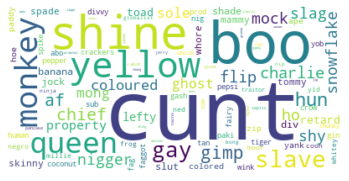

         count
term          
cunt      2134
boo       1031
shine      627
yellow     484
cunts      414
queen      325
monkey     282
gay        174
slave      121
hun        120
gimp       108
af         100
chief       96
flip        89
charlie     89
mock        84
slaves      83
monkeys     80
ho          80
shy         77


In [ ]:
create_slur_wordcloud("matching_hatebase_terms_over_70_four_letter")

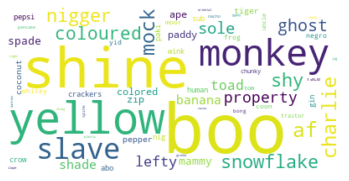

           count
term            
boo         1031
shine        627
yellow       484
monkey       282
slave        121
af           100
charlie       89
mock          84
slaves        83
monkeys       80
shy           77
snowflake     76
coloured      66
ghost         59
sole          56
property      50
nigger        44
lefty         44
toad          40
shade         34


In [ ]:
create_slur_wordcloud("matching_hatebase_terms_ethnicity_four_letter_over_70")

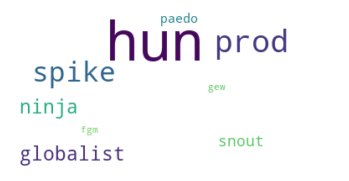

           count
term            
hun          120
prod          15
spike         12
globalist      5
ninja          5
snout          3
paedo          2
fgm            1
gew            1


In [ ]:
create_slur_wordcloud("matching_hatebase_terms_religion_four_letter_over_70")

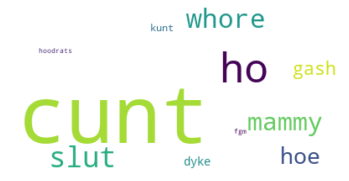

          count
term           
cunt       2134
cunts       414
ho           80
whore        27
mammy        26
slut         26
hoe          20
gash         13
sluts         6
dyke          4
kunt          3
fgm           1
hoodrats      1


In [ ]:
create_slur_wordcloud("matching_hatebase_terms_gender_four_letter_over_70")

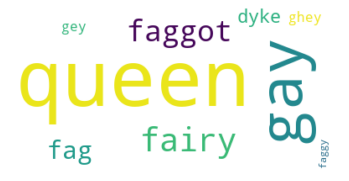

         count
term          
queen      325
gay        174
fairy       16
faggot      11
fag          9
dyke         4
faggots      2
gey          2
ghey         2
faggy        1


In [ ]:
create_slur_wordcloud("matching_hatebase_terms_sexual_orientation_four_letter_over_70")

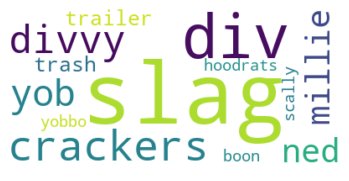

               count
term                
slag              72
div               30
crackers          12
divvy             10
yob                9
millie             7
ned                7
trailer trash      2
boon               1
hoodrats           1
scally             1
yobbo              1


In [ ]:
create_slur_wordcloud("matching_hatebase_terms_class_four_letter_over_70")

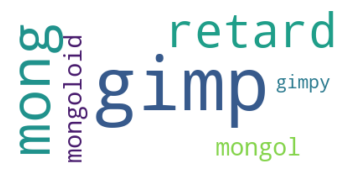

           count
term            
gimp         108
mong          54
retard        39
mongol         2
mongoloid      2
gimpy          1


In [ ]:
create_slur_wordcloud("matching_hatebase_terms_disability_four_letter_over_70")

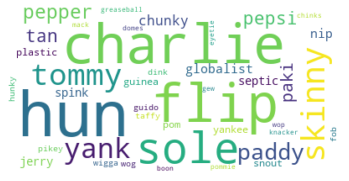

               count
term                
hun              120
flip              89
charlie           89
sole              56
skinny            27
tommy             26
yank              22
paddy             17
pepper            14
pepsi             11
paki               9
tan                7
chunky             6
nip                5
globalist          5
jerry              4
septic             4
tans               4
plastic paddy      3
pom                3


In [ ]:
create_slur_wordcloud("matching_hatebase_terms_nationality_four_letter_over_70")

# Visulisations - tweet frequency

In [ ]:
# Setup vars for high-profile tweet times
# "id": "1415692762708680717"
saka_tweet_time = "2021-07-15T15:20:31.000Z"

# "id": "1414672529717964807"
rashford_tweet_time = "2021-07-12T19:46:29.000Z"

# "id": "1415348669809823751"
sancho_tweet_time = "2021-07-14T16:33:13.000Z"

# "id": "1414639048031805441"
kane_tweet_time = "2021-07-12T17:33:26.000Z",

# "id": "1414654985753841667"
mings_tweet_time = "2021-07-12T18:36:46.000Z"

# "id": "1414654987246911490"
# mings_second_tweet_time = "2021-07-12T18:36:46.000Z"

# "id": "1414655312074784785"
# mings_third_tweet_time = "2021-07-12T18:38:04.000Z"

In [ ]:
def create_frequency_plot(resample, saka_line=False, sancho_line=False, kane_line=False, rashford_line=False, mings_line=False):
    fig, ax = plt.subplots(figsize=(12, 7))
    ax = (resample.plot.line(ax=ax))
    if saka_line:
        plt.axvline(pd.to_datetime(saka_tweet_time))
    if rashford_line:
        plt.axvline(pd.to_datetime(rashford_tweet_time))
    if sancho_line:
        plt.axvline(pd.to_datetime(sancho_tweet_time))
    if kane_line:
        plt.axvline(pd.to_datetime(kane_tweet_time))
    if mings_line:
        plt.axvline(pd.to_datetime(mings_tweet_time))
    plt.show()

In [ ]:
INTERVAL = pd.offsets.Minute(5)

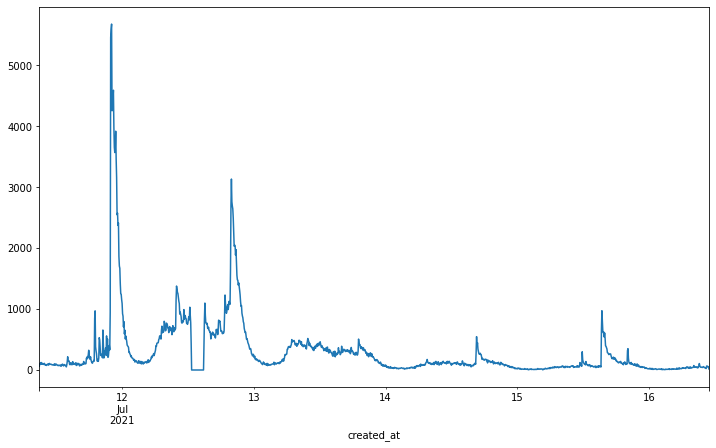

In [ ]:
# Plot all tweets frequency
resample = players_only_df.resample(INTERVAL, on='created_at')['tweet_id'].count()
create_frequency_plot(resample)

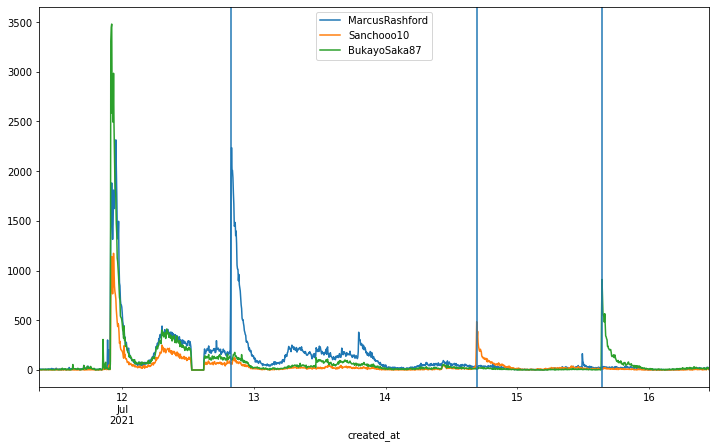

In [ ]:
# Plot Rashford, Saka, Sancho tweet frequency
resample = players_only_df.resample(INTERVAL, on='created_at')['MarcusRashford', 'Sanchooo10', 'BukayoSaka87'].sum()
create_frequency_plot(resample, saka_line=True, sancho_line=True, rashford_line=True)

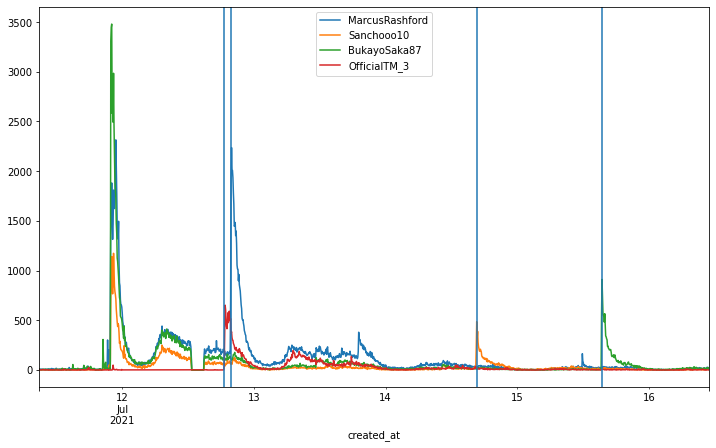

In [ ]:
# Plot Rashford, Saka, Sancho, Mings tweet frequency
resample = players_only_df.resample(INTERVAL, on='created_at')['MarcusRashford', 'Sanchooo10', 'BukayoSaka87', 'OfficialTM_3'].sum()
create_frequency_plot(resample, saka_line=True, sancho_line=True, rashford_line=True, mings_line=True)

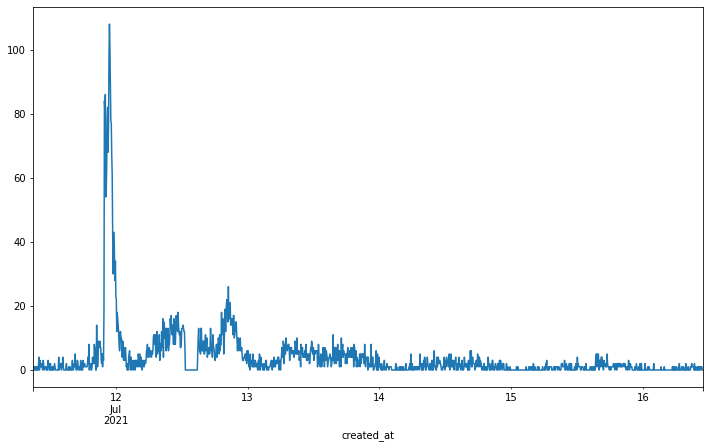

In [ ]:
# Plot frequency of offensive tweets
resample = players_only_df.resample(INTERVAL, on='created_at')['contains_slurs_or_offensive_emoji'].sum()
create_frequency_plot(resample)

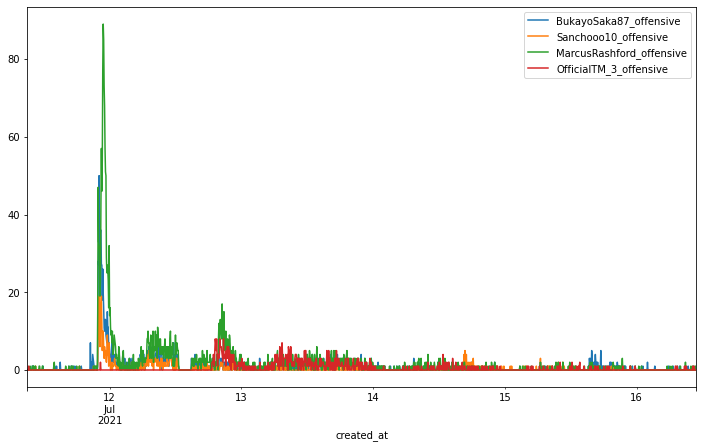

In [ ]:
# Plot frequency of offensive tweets for Rashford, Sancho, Saka, Mings
resample = players_only_df.resample(INTERVAL, on='created_at')['BukayoSaka87_offensive', 'Sanchooo10_offensive', 'MarcusRashford_offensive', 'OfficialTM_3_offensive'].sum()
create_frequency_plot(resample)

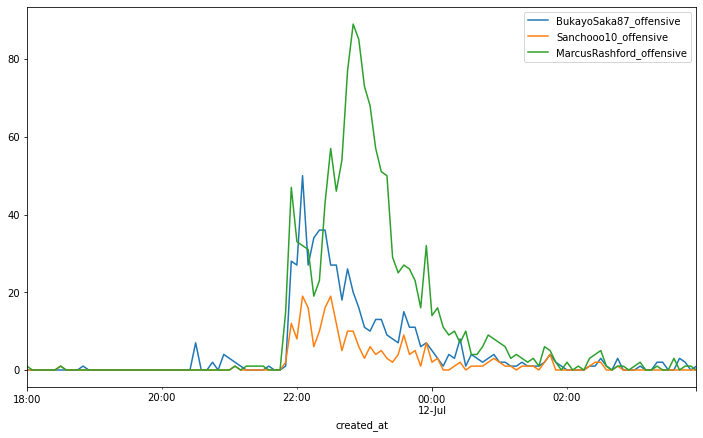

In [ ]:
# Plot Sancho, Saka, Rashford immediately after the final
resample = players_only_df[(players_only_df['created_at'] > '2021-07-11 18:00:00+00:00') & (players_only_df['created_at'] < '2021-07-12 04:00:00+00:00')].resample(INTERVAL, on='created_at')['BukayoSaka87_offensive', 'Sanchooo10_offensive', 'MarcusRashford_offensive'].sum()
create_frequency_plot(resample)

In [167]:
player_offensive_tweet_map.sort_values('offensive_tweets_received', ascending=False, inplace=True)

def create_ethnicity_stack_chart(number):
    df = player_offensive_tweet_map.head(number)
    data0 = go.Bar(
        x = df.username,
        y = df.ethnicity_tweets_received,
        name = 'Ethnicity-related',
        text = df.ethnicity_tweets_received,
        textposition = 'inside',
        texttemplate = '%{text:.2}'
    )

    data1 = go.Bar(
        x = df.username,
        y = df.offensive_tweets_received - df.ethnicity_tweets_received,
        name = 'Other',
        text = df.offensive_tweets_received - df.ethnicity_tweets_received,
        textposition = 'inside',
        texttemplate = '%{text:.2}'
    )

    data = [data1, data0]

    layout = go.Layout(title = "Proportion of tweets containing abusive slurs where slurs related to ethnicity", barmode='stack')

    figure = go.Figure(data = data, layout = layout)
    figure.show()



# Visualisations - stack charts

In [168]:
create_ethnicity_stack_chart(4)

In [170]:
slurs_by_type.sort_values('total', ascending=False, inplace=True)

data = go.Bar(
    x = slurs_by_type['type'],
    y = slurs_by_type.total,
    text = slurs_by_type.total,
    textposition = 'outside',
    texttemplate = '%{text:.2}'
)

layout = go.Layout(title = "Tweets containing slurs by type")

figure = go.Figure(data = data, layout = layout)
figure.show()